In [1]:
# import os
# os.chdir('../') #if we are in notebooks folder

In [2]:
%pip install -q flax
# %pip install -q "jax[tpu]>=0.2.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

     |████████████████████████████████| 197 kB 7.4 MB/s 
     |████████████████████████████████| 596 kB 53.1 MB/s 
     |████████████████████████████████| 140 kB 73.0 MB/s 
     |████████████████████████████████| 217 kB 65.7 MB/s 
     |████████████████████████████████| 51 kB 9.0 MB/s 
     |████████████████████████████████| 72 kB 728 kB/s 


In [3]:
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

In [4]:
import flax
import flax.linen as nn
import tensorflow_probability.substrates.jax as tfp


import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from sklearn import datasets
from sklearn import preprocessing as sp

try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

# from models import mc_dropout
# from utils import fit

from functools import partial

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 272 kB 9.4 MB/s 
     |████████████████████████████████| 88 kB 8.4 MB/s 
     |████████████████████████████████| 119 kB 70.3 MB/s 
     |████████████████████████████████| 1.1 MB 59.7 MB/s 


In [35]:
latexify(fig_height=2)

In [7]:
dist = tfp.distributions

In [8]:
co2_dataset = datasets.fetch_openml(data_id=41187, as_frame=True)

In [9]:
co2_dataset.frame.head()

,year,month,day,weight,flag,station,co2
0,1958.0,3.0,29.0,4.0,0.0,MLO,316.1
1,1958.0,4.0,5.0,6.0,0.0,MLO,317.3
2,1958.0,4.0,12.0,4.0,0.0,MLO,317.6
3,1958.0,4.0,19.0,6.0,0.0,MLO,317.5
4,1958.0,4.0,26.0,2.0,0.0,MLO,316.4


In [10]:
co2_df = co2_dataset.frame
co2_df["date"] = pd.to_datetime(co2_df[["year", "month", "day"]])
co2_df = co2_df[["date", "co2"]].set_index("date")

In [11]:
co2_df.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [12]:
co2_df = co2_df.resample("M").mean().dropna(axis="index", how="any")

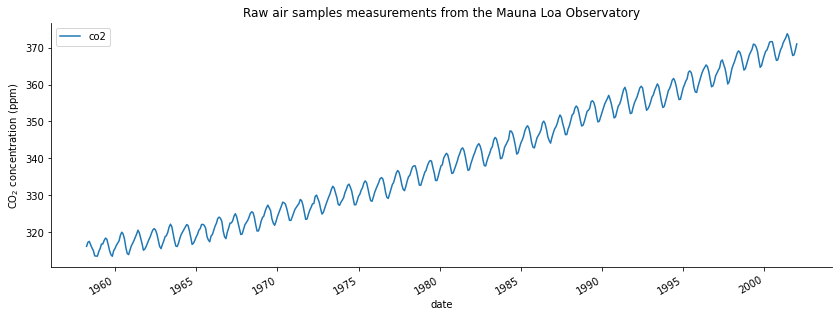

In [13]:
co2_df.plot(figsize=(14, 5))
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")
sns.despine()

In [14]:
X = (co2_df.index.year + co2_df.index.month / 12).to_numpy().reshape(-1, 1)

In [15]:
s = 200
n = 450
scaler = sp.StandardScaler()
scaler = scaler.fit(X[s:n])
x = scaler.transform(X[s:n])

In [16]:
y = jnp.array(co2_df["co2"][s:n])
min_max = sp.MinMaxScaler(feature_range=(0, 5))
min_max = min_max.fit(y.reshape(-1, 1))
y = min_max.transform(y.reshape(-1, 1))

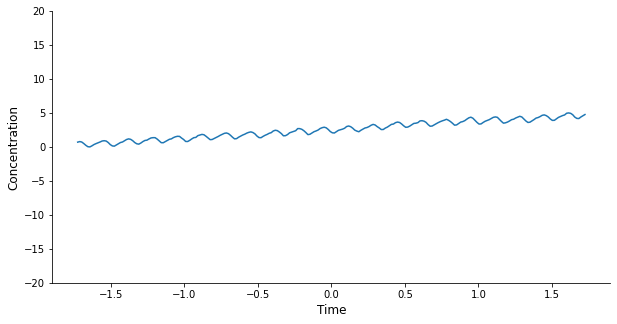

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.ylim(-20, 20)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Concentration", fontsize=12)
sns.despine()

# Train

In [18]:
class mc_dropout(nn.Module):
    features: list

    @nn.compact
    def __call__(self, x, deterministic=True, rate=0.1):

        for i, feature in enumerate(self.features):
            x = nn.Dense(feature)(x)
            x = nn.relu(x)
            x = nn.Dropout(rate=rate, deterministic=deterministic)(x)

        x = nn.Dense(1)(x)
        return x

    def loss_fn(
        self, params, x, y, deterministic=False, rate=0.1, rng=jax.random.PRNGKey(0)
    ):
        # key = jax.random.PRNGKey(0)
        y_pred = self.apply(params, x, deterministic, rate, rngs={"dropout": rng})
        loss = jnp.mean((y - y_pred) ** 2)
        return loss

In [19]:
def fit(model, params, auxs, learning_rate=0.01, epochs=1000, verbose=False):
    opt = optax.adam(learning_rate=learning_rate)
    opt_state = opt.init(params)

    partial_loss_fn = partial(
        model.loss_fn, deterministic=auxs["deterministic"], rate=auxs["rate"]
    )
    loss_grad_fn = jax.jit(jax.value_and_grad(partial_loss_fn))
    losses = []
    upd = jax.jit(opt.update)
    x, y = auxs["X"], auxs["y"]
    rng = jax.random.PRNGKey(0)
    try:
        for i in range(epochs):
            rng, _ = jax.random.split(rng)
            loss_val, grads = loss_grad_fn(params, x, y, rng=rng)
            updates, opt_state = upd(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            losses.append(loss_val)
            if verbose and i % (epochs / 10) == 0:
                print("Loss step {}: ".format(i), loss_val)
    except KeyboardInterrupt:
        print("got it.")
        return params, jnp.array(losses)
    return params, jnp.array(losses)

In [20]:
# load the model
model = mc_dropout(features=[256, 512, 256, 128])

In [21]:
# initialize model
params = model.init(jax.random.PRNGKey(0), x)

In [22]:
# model.tabulate(jax.random.PRNGKey(1), x, deterministic=True)

In [23]:
auxs = {"X": x, "y": y, "deterministic": False, "rate": 0.1}
params, losses = fit(
    model, params, auxs, learning_rate=0.0005, epochs=100000, verbose=True
)

Loss step 0:  7.9703736
Loss step 10000:  0.082933635
Loss step 20000:  0.069000244
Loss step 30000:  0.04705535
Loss step 40000:  0.04445836
Loss step 50000:  0.033236522
Loss step 60000:  0.031122293
Loss step 70000:  0.029002804
Loss step 80000:  0.028685274
Loss step 90000:  0.026861954


/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


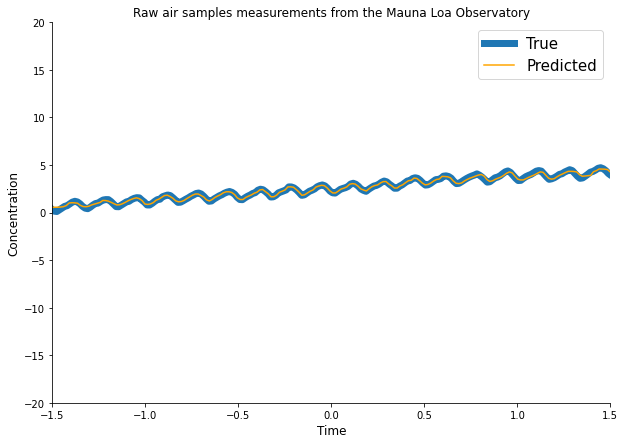

In [24]:
x_grid = jnp.linspace(-1.5, 1.5, 200).reshape(-1, 1)
plt.figure(figsize=(10, 7))
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")
plt.plot(x, y, linewidth=7, label="True")

plt.plot(x_grid, model.apply(params, x_grid), "orange", label="Predicted")
sns.despine()
plt.legend(fontsize=15)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Concentration", fontsize=12)
plt.xlim(-1.5, 1.5)
plt.ylim(-20, 20)
savefig("Mauna_loa_CO2_")

# MC_Dropout


In [41]:
def eval(params, x, deterministic=False, rate=0.1, rng=jax.random.PRNGKey(0)):
    return model.apply(params, x, deterministic=False, rate=0.1, rngs={"dropout": rng})

In [42]:
x_test = jnp.linspace(-1.5, 3, 200).reshape(-1, 1)
n_stacks = 100
y_stacks = []
partial_eval_fn = partial(eval, deterministic=False, rate=0.1)
evaluate = jax.jit(partial_eval_fn)
for i in range(n_stacks):
    y_stacks.append(evaluate(params, x_test, rng=jax.random.PRNGKey(i)))

In [43]:
y_stacks = jnp.array(y_stacks)

saving image to "figure/"/Uncertain_Co2_Prediction_latexified.pdf
Figure size: [6. 2.]


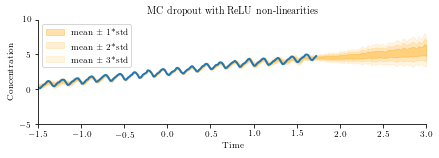

In [44]:
plt.figure()
plt.title("MC dropout with ReLU non-linearities", fontsize=10)
plt.plot(x, y, linewidth=2)
mean = (y_stacks.mean(axis=0)).squeeze()
std = (y_stacks.std(axis=0)).squeeze()
for i in range(1, 4):
    plt.fill_between(
        x_test.squeeze(),
        mean - i * std,
        mean + i * std,
        color="orange",
        alpha=1 / (i * 3),
        label=f"mean $\pm$ {i}*std",
    )
plt.legend(loc="upper left")
sns.despine()
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.ylim(-5, 10)
plt.xlim(-1.5, 3)
savefig("Uncertain_Co2_Prediction", bbox_inches="tight", pad=1)

In [29]:
x_test = jnp.linspace(-1.5, 3.5, 200).reshape(-1, 1)
n_stacks = 100
y_stacks = []
partial_eval_fn = partial(eval, deterministic=False, rate=0.1)
evaluate = jax.jit(partial_eval_fn)
for i in range(n_stacks):
    r_y = evaluate(params, x_test, rng=jax.random.PRNGKey(i))
    r_y = min_max.inverse_transform(r_y)
    y_stacks.append(r_y)

In [30]:
y_stacks = jnp.array(y_stacks)

In [31]:
mean = (y_stacks.mean(axis=0)).squeeze()
std = (y_stacks.std(axis=0)).squeeze()

In [32]:
r_x = scaler.inverse_transform(x)
x_test = scaler.inverse_transform(x_test)
r_y = co2_df["co2"][s:n]

saving image to "figure/"/Uncertain_Co2_Prediction_rescale_latexified.pdf
Figure size: [6. 2.]


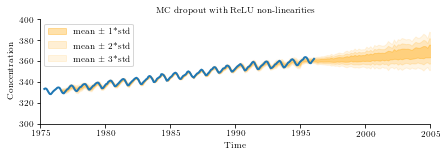

In [39]:
plt.figure()
plt.title("MC dropout with ReLU non-linearities")
plt.plot(r_x, r_y, linewidth=2)

for i in range(1, 4):
    plt.fill_between(
        x_test.squeeze(),
        mean - i * std,
        mean + i * std,
        color="orange",
        alpha=1 / (i * 3),
        label=f"mean $\pm$ {i}*std",
    )
plt.legend(loc="upper left")
sns.despine()
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.ylim(300, 400)
plt.xlim(1975, 2005)
savefig("Uncertain_Co2_Prediction_rescale", bbox_inches="tight", pad=1)